The column heading variables have the following meanings:

- survival: Survival (0 = no; 1 = yes)
- class: Passenger class (1 = first; 2 = second; 3 = third)
- name: Name
- sex: Sex
- age: Age
- sibsp: Number of siblings/spouses aboard
- parch: Number of parents/children aboard
- ticket: Ticket number
- fare: Passenger fare
- cabin: Cabin
- embarked: Port of embarkation (C = Cherbourg; Q = Queenstown; S = Southampton)
- boat: Lifeboat (if survived)
- body: Body number (if did not survive and body was recovered)

In [77]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing, svm, tree
%matplotlib inline
sns.set(style='white', color_codes=True)

In [78]:
df = pd.read_csv('titanic_train.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Analysing the data

First, let’s examine the overall chance of survival for a Titanic passenger.

In [79]:
df['Survived'].mean()

0.3838383838383838

To get a view into the composition of each class, we can group data by class, and view the averages for each column:

In [80]:
df.groupby('Pclass').mean()

,PassengerId,Survived,Age,SibSp,Parch,Fare
Pclass,,,,,,
1,461.597222,0.629630,38.233441,0.416667,0.356481,84.154687
2,445.956522,0.472826,29.877630,0.402174,0.380435,20.662183
3,439.154786,0.242363,25.140620,0.615071,0.393075,13.675550


In [34]:
class_sex_grouping = df.groupby(['Pclass','Sex']).mean()
class_sex_grouping

# across all classes, women were much more likely to survive than the men
# women were younger than the men on average, were more likely to be traveling with family, 
# and paid slightly more for their tickets

PassengerId  Survived        Age     SibSp     Parch  \
Pclass Sex                                                            
1      female   469.212766  0.968085  34.611765  0.553191  0.457447   
       male     455.729508  0.368852  41.281386  0.311475  0.278689   
2      female   443.105263  0.921053  28.722973  0.486842  0.605263   
       male     447.962963  0.157407  30.740707  0.342593  0.222222   
3      female   399.729167  0.500000  21.750000  0.895833  0.798611   
       male     455.515850  0.135447  26.507589  0.498559  0.224784   

                     Fare  
Pclass Sex                 
1      female  106.125798  
       male     67.226127  
2      female   21.970121  
       male     19.741782  
3      female   16.118810  
       male     12.661633

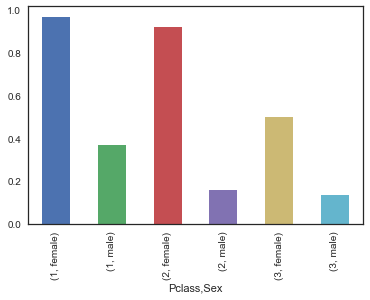

In [35]:
class_sex_grouping['Survived'].plot.bar()

What about Children ?

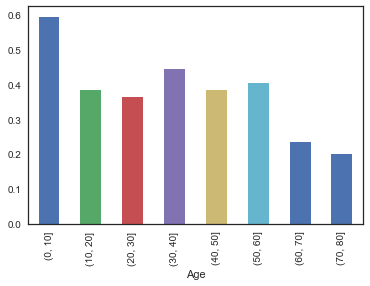

In [36]:
group_by_age = pd.cut(df["Age"], np.arange(0, 90, 10))
age_grouping = df.groupby(group_by_age).mean()
age_grouping['Survived'].plot.bar()

### Why ML ?

We will build a program that learns from the sample data to predict whether a given passenger would survive

### Preparing The Data

Before we can feed our data set into a machine learning algorithm, we have to remove missing values and split it into training and test sets.

In [81]:
df.count()
# check which column has how many null values

PassengerId    891
Survived       891
Pclass         891
Name           891
Sex            891
Age            714
SibSp          891
Parch          891
Ticket         891
Fare           891
Cabin          204
Embarked       889
dtype: int64

In [82]:
# drop null values
df = df.drop(['Cabin'], axis = 1)

In [83]:
# get rid of the null values
df = df.dropna()

In [84]:
# What about now ?
df.count()

PassengerId    712
Survived       712
Pclass         712
Name           712
Sex            712
Age            712
SibSp          712
Parch          712
Ticket         712
Fare           712
Embarked       712
dtype: int64

In [41]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


Now we need to format the remaining data in a way that our machine learning algorithms will accept.

The “Sex” and “Embarked” fields are both string values that correspond to categories (i.e “Male” and “Female”) so we will run each through a preprocessor. This preprocessor will convert these strings into integer keys, making it easier for the classification algorithms to find patterns. For instance, “Female” and “Male” will be converted to 0 and 1 respectively. The “name” and “ticket” columns consist of non-categorical string values. These are difficult to use in a classification algorithm, so we will drop them from the data set.

In [85]:
df = df.drop(['Ticket', 'Name'], axis = 1)

In [88]:
processed_df = df.copy()
# Check what are the categories in the Embarked column
label_encoder = sklearn.preprocessing.LabelEncoder()
processed_df.Sex = label_encoder.fit_transform(processed_df.Sex)
processed_df.Embarked = label_encoder.fit_transform(processed_df.Embarked)

In [89]:
processed_df.head(20)

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,1,22.0,1,0,7.2500,2
1,2,1,1,0,38.0,1,0,71.2833,0
2,3,1,3,0,26.0,0,0,7.9250,2
3,4,1,1,0,35.0,1,0,53.1000,2
4,5,0,3,1,35.0,0,0,8.0500,2
6,7,0,1,1,54.0,0,0,51.8625,2
7,8,0,3,1,2.0,3,1,21.0750,2
8,9,1,3,0,27.0,0,2,11.1333,2
9,10,1,2,0,14.0,1,0,30.0708,0
10,11,1,3,0,4.0,1,1,16.7000,2


In [57]:
# Will age and fare be a problem for us ? Why ?
mmScale = sklearn.preprocessing.MinMaxScaler()
processed_df.Age = mmScale.fit_transform(processed_df.Age.reshape(-1,1))
processed_df.Fare = mmScale.fit_transform(processed_df.Fare.reshape(-1,1))

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  after removing the cwd from sys.path.


In [90]:
processed_df.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,1,22.0,1,0,7.2500,2
1,2,1,1,0,38.0,1,0,71.2833,0
2,3,1,3,0,26.0,0,0,7.9250,2
3,4,1,1,0,35.0,1,0,53.1000,2
4,5,0,3,1,35.0,0,0,8.0500,2


In [92]:
# What are we trying to predict ? remove the label.
X = processed_df.drop(['Survived'], axis=1).values
y = processed_df['Survived'].values

In [93]:
# Train - Test split the data
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X,y,test_size=0.2)

![classifier tree](image00.png)

The tree first splits by sex, and then by class, since it has learned during the training phase that these are the two most important features for determining survival. The dark blue boxes indicate passengers who are likely to survive, and the dark orange boxes represent passengers who are almost certainly doomed. Interestingly, after splitting by class, the main deciding factor determining the survival of women is the ticket fare that they paid, while the deciding factor for men is their age (with children being much more likely to survive).

In [94]:
# Decision Tree
clf_dt = tree.DecisionTreeClassifier(max_depth=10)

In [95]:
clf_dt.fit (X_train, y_train)
clf_dt.score (X_test, y_test)

0.7622377622377622

In [96]:
# Is it dependent on data split that we are using ?
shuffle_validator = cross_validation.ShuffleSplit(len(X), n_iter=20, test_size=0.2, random_state=0)
def test_classifier(clf):
    scores = cross_validation.cross_val_score(clf, X, y, cv=shuffle_validator)
    print("Accuracy: %0.4f (+/- %0.2f)" % (scores.mean(), scores.std()))

In [101]:
test_classifier(clf_dt)

Accuracy: 0.7636 (+/- 0.03)


# Other Algorithms

In [102]:
import sklearn.ensemble as ske
clf_rf = ske.RandomForestClassifier(n_estimators=50)
test_classifier(clf_rf)

Accuracy: 0.8154 (+/- 0.03)


In [103]:
clf_gb = ske.GradientBoostingClassifier(n_estimators=50)
test_classifier(clf_gb)

Accuracy: 0.8224 (+/- 0.03)


In [104]:
eclf = ske.VotingClassifier([('dt', clf_dt), ('rf', clf_rf), ('gb', clf_gb)])
test_classifier(eclf)

/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

Accuracy: 0.8157 (+/- 0.03)


/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
